# Project: Identifying Facial Keypoints.

## Problem Statement:
Identify facial landmarks of human face, outlining the person's eyebrows, eyes, nose, lips and jawline.

## Project Planning:

The project is divided into the following tasks and, each task is carried out in it's respective Jupyter Notebook.

**1. Define Netowrk Architecture**
  1. Fetching Data
  2. Data Transformation
  3. Batching and Loading Data
  4. Training
  5. Testing
  6. Feature Visualization

**2. Facial Keypoint Detection Complete Pipeline**
  1. Loading Model
  2. Importing image
  3. Extracting Faces
  4. Identify facial keypoints

### Imports


In [ ]:
# Import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# Import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# Importing PyTorch libraries needed
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Using CUDA if available
use_cuda = torch.cuda.is_available()

### 1. Fetching the data

In [ ]:
# Fetching the Image Data

!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2022-07-24 02:30:53--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.69.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.69.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  65.9MB/s    in 5.0s    

2022-07-24 02:30:59 (64.0 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [ ]:
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (dense1): Linear(in_features=8192, out_features=3000, bias=True)
  (dense2): Linear(in_features=3000, out_features=800, bias=True)
  (dense3): Linear(in_features=800, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (drop5): Dropout(p=0.4, inplace=False)
  (drop6): Dropout(p=0.4, inplace=False)
  (drop7): Dropout(p=0.4, inplace=False)
)


## 2. Data Transformation

To prepare data for training, transforming the dataset of images and keypoints so that model's loss doesn't blow up during training and also all images are brought to same size. The below transformations are applied onn the data:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px).
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1].
3. Turning these images and keypoints into Tensors.


These same transformations have been defined in `data_load.py`.


In [ ]:
# The dataset we created earlier is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset

# The code for transformations we decided to perform are in the helper file `data_load.py`, using those functions here.
from data_load import Rescale, RandomCrop, Normalize, ToTensor


data_transform = transforms.Compose([Rescale(250), 
                                     RandomCrop(224), 
                                     Normalize(), 
                                     ToTensor()])

# Testing whether the transform is defined.
assert(data_transform is not None), 'Define a data_transform'

In [ ]:
# Creating the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# Let's iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## 3. Batching and Loading data

Using PyTorch's DataLoader class to load the training data in batches and to shuffle the data for training the model. 

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [ ]:
# load training data in batches
batch_size = 128

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=2)

## 4. Training

In [ ]:
# Defining the loss function and optimizer.
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


In [ ]:
def train_net(net, n_epochs):

    # Preparing the net for training
    net.train()

    for epoch in range(n_epochs): 
        
        running_loss = 0.0

        #Train on batches of data, assumes you already have train_loader

        for batch_i, data in enumerate(train_loader):
            # Get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # Flatten keypoints
            key_pts = key_pts.view(key_pts.size(0), -1)

            # Convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # Use GPU if available
            if use_cuda:
              net, images, key_pts = net.cuda(), images.cuda(), key_pts.cuda()

            # Forward pass to get outputs
            output_pts = net(images)

            # Calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # Zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [ ]:
# Training the network

with active_session():
  train_net(net, n_epochs = 20)

Epoch: 1, Batch: 10, Avg. Loss: 0.275850473344326
Epoch: 1, Batch: 20, Avg. Loss: 0.14607673957943917
Epoch: 2, Batch: 10, Avg. Loss: 0.09360361322760583
Epoch: 2, Batch: 20, Avg. Loss: 0.10331740751862525
Epoch: 3, Batch: 10, Avg. Loss: 0.09880274087190628
Epoch: 3, Batch: 20, Avg. Loss: 0.09512784704566002
Epoch: 4, Batch: 10, Avg. Loss: 0.09248249754309654
Epoch: 4, Batch: 20, Avg. Loss: 0.09805991500616074
Epoch: 5, Batch: 10, Avg. Loss: 0.09352097064256668
Epoch: 5, Batch: 20, Avg. Loss: 0.10022849217057228
Epoch: 6, Batch: 10, Avg. Loss: 0.09706502258777619
Epoch: 6, Batch: 20, Avg. Loss: 0.09490066915750503
Epoch: 7, Batch: 10, Avg. Loss: 0.09681310504674911
Epoch: 7, Batch: 20, Avg. Loss: 0.09259174317121506
Epoch: 8, Batch: 10, Avg. Loss: 0.09254800304770469
Epoch: 8, Batch: 20, Avg. Loss: 0.10096283853054047
Epoch: 9, Batch: 10, Avg. Loss: 0.09186948314309121
Epoch: 9, Batch: 20, Avg. Loss: 0.09458509981632232
Epoch: 10, Batch: 10, Avg. Loss: 0.09222450107336044
Epoch: 10, Ba

## 5. Testing

Let's test the model with some test data and observe it's performance. To achieve this, below actions need to be done while creating a test pipeline from passing the images till visualizing the output.
1. Creating a Test dataloader.
2. Apply model to the test images.
3. Un-transform the keypoints - Rescale keypoints to original scale and convert them from Tensors to Numpy array.
4. Show the face image with predicted and ground truth keypoints.

### 5.1 Creating a Test dataloader



In [ ]:
# Loading the test data, using the dataset class and applying the data_transform defined above

test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

# Loading test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=2)

### 5.2 Apply the model on test images

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [ ]:
# test the model on a batch of test images

def net_sample_output(net):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader): # 1 batch is loaded at a time, so sample is a batch of 10 images
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        if use_cuda:
          net, images, key_pts = net.cuda(), images.cuda(), key_pts.cuda()

        # forward pass to get net output
        output_pts = net(images)
        print("Outputs size before: ",output_pts.size())
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts.cpu()
            

### 5.3 Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points. Also, we have to "un-transform" the image/keypoint data to display it (Step 5.4).

I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


### 5.4 Un-transformation

The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform

The helper function defined below `visualize_output` takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints. This function's main role is to take batches of image and keypoint data (the input and output of CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display.

In [ ]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        test_images = test_images.cpu()
        test_outputs = test_outputs.cpu()

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()


### 5.5 Visualizing Test Output

In [ ]:
# Getting a sample of test data
test_images, test_outputs, gt_pts = net_sample_output(net)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

Outputs size before:  torch.Size([10, 136])
torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


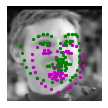

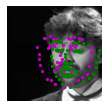

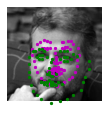

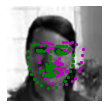

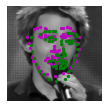

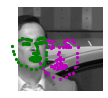

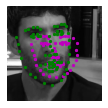

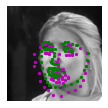

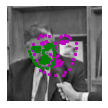

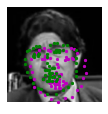

In [ ]:
# Visualizing the test output

visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
# Saving the Model
model_name = 'keypoints_model_1.pt'

torch.save(net.state_dict(), model_name)

## 6. Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. Feature visualization is useful for understanding the inner workings of a CNN.

[[-0.03142655  0.20442328  0.16187732 -0.08796235  0.10725329]
 [ 0.00618571 -0.0192302  -0.00945792 -0.17030561 -0.00439372]
 [ 0.19574282  0.06915586  0.14931339 -0.1141816  -0.0605127 ]
 [-0.10490266 -0.1525383  -0.06717268 -0.09010848  0.01784328]
 [-0.04664566  0.10247653 -0.07126406 -0.14204736 -0.0808074 ]]
(5, 5)
(32, 1, 5, 5)
(1, 5, 5)


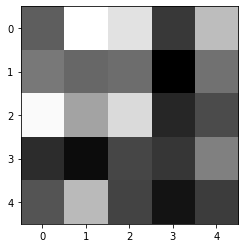

In [ ]:
# Transfering the model to cpu
net = net.cpu()

weights1 = net.conv1.weight.data

w1 = weights1.numpy()

filter_index = 0

print(w1[filter_index][0])
print(w1[filter_index][0].shape)
print(w1.shape)
print(w1[filter_index].shape)
# display the filter weights
plt.imshow(w1[filter_index][0], cmap='gray')


[[ 0.00073281  0.00765173 -0.01124974 -0.03786244  0.01662861]
 [ 0.02296965 -0.04126337 -0.0128226  -0.00975719  0.02319367]
 [ 0.007455   -0.00437964 -0.02413124  0.00654894 -0.03783242]
 [-0.01879432  0.01716431 -0.02857078  0.01533461  0.00524795]
 [-0.01327392 -0.00781494 -0.04072866 -0.02955534 -0.02209141]]
(5, 5)
(64, 32, 5, 5)
(32, 5, 5)


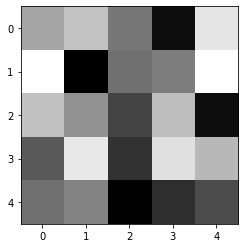

In [ ]:
weights2 = net.conv2.weight.data

w = weights2.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)
print(w.shape)
print(w[filter_index].shape)
# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')